In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
# Начальная форма ДатаФрейма
df = pd.DataFrame(columns = ['ids', 'text', 'score'])
for bar in ['train/', 'test/']:
    for ton in ['pos', 'neg']:
        tmp_df = pd.DataFrame()
        
        os.chdir(bar+ton)
        files = os.listdir()

        ids = []
        feedbacks = []
        scores = []

        for file in files:
            feedback=''
            tmp_id = file.split('_')[0]
            tmp_score = file.split('_')[1][:-4]
            with open(file, encoding='utf-8') as f:
                for line in f:
                    feedback += line
            ids.append(tmp_id)
            feedbacks.append(feedback)
            scores.append(tmp_score)
        os.chdir('../..')
    
        tmp_df['ids'] = ids
        tmp_df['text'] = feedbacks
        tmp_df['score'] = scores
        df = df.append(tmp_df)

In [3]:
print('df_shape: {}'.format(df.shape))
df.head()

df_shape: (50000, 3)


,ids,text,score
0,4715,For a movie that gets no respect there sure ar...,9
1,12390,Bizarre horror movie filled with famous faces ...,8
2,8329,"A solid, if unremarkable film. Matthau, as Ein...",7
3,9063,It's a strange feeling to sit alone in a theat...,8
4,3092,"You probably all already know this by now, but...",10


Посмотрев на содержимое отзывов, можно заметить, что при парсинге захватывались
различные теги, и предобработка данных не провалидась.

In [5]:
np.seed = 42
df.iloc[np.random.randint(50_000), 1]

'Really it\'s a dreadful cheat of a film. Its 70-minute running time is very well padded with stock footage. The rest are non descript exteriors and drab interiors scenes. The plot exposition is very poorly rendered. They are all just perfunctory scenes sort of strung together. There is no attempt at drama in scene selection but rather drama is communicated by the intensity of the actors. Please don\'t ask.<br /><br />The plot concerns a rocket radiating a million degree heat orbiting earth five miles up threatening to destroy the earth. It\'s a real time menace that must be diverted if a custom built H-bomb can be fashioned and placed in an experimental rocket within an hour. Nothing very much here to report except for a mad speech by a scientist against the project because there might be some sort of life aboard and think of the scientific possibilities but this speech made by the obligatory idiot liberal was pretty much passé by then.<br /><br />What saves this film, somewhat unique

## Предварительная чистка данных

In [6]:
from bs4 import BeautifulSoup
import re

In [7]:
# Удаление тегов
def strip_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()


# Удаление квадратных скобок
def remove_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)


# Общая чистка
def clean_text(text):
    text = strip_html(text)
    text = remove_square_brackets(text)
    return text

df['text'] = df['text'].apply(clean_text)

In [8]:
# Глубокая чистка 
def deep_cleaning(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text)
    return text

df['text'] = df['text'].apply(deep_cleaning)

## Преобразование данных  
Для начала стоит перемешать данные.  
Векторизуем все наше множество слов с помощью ***TF-IDF*** преобразований.  
Также используем **n-граммы** длинны два (*биграммы*). 

In [9]:
df = df.sample(frac=1)
df.head()

,ids,text,score
11097,9695,WARNING Dont even consider watching this film ...,1
1378,12497,Im sure that the folks on the TexasLouisiana b...,4
2429,5300,I found this film to funny from the start John...,8
6456,4878,After seeing this film I did not want my money...,1
11312,9612,I wont be too hard on this show because I enjo...,2


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [11]:
train_score=df.score[:40000]
train_review=df.text[:40000]
test_score=df.score[40000:]
test_review=df.text[40000:]

In [12]:
tf_idf_vec = TfidfVectorizer(min_df = 20, max_df = 0.5, ngram_range=(1, 2))

matrix_train_review = tf_idf_vec.fit_transform(train_review)
matrix_test_reiew = tf_idf_vec.transform(test_review)

matrix_train_review.shape, matrix_test_reiew.shape

((40000, 60403), (10000, 60403))

## Обучение
Выбор пал на **логистическую регрессию** потому, что она хорошо спавляется с сильно разреженными данными.
В виду размеров обучающей выборки можно не использовать кросс-валидацию.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [14]:
logit = LogisticRegression(C = 1, random_state=42, max_iter=1000)
logit.fit(matrix_train_review, train_score)
tmp = logit.predict(matrix_train_review)
print("overfit?\naccuracy: ",accuracy_score(list(tmp), train_score))
      
predict = logit.predict(matrix_test_reiew)

/Users/user/Documents/GitHub/mlcourse.ai/env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/user/Documents/GitHub/mlcourse.ai/env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


overfit?
accuracy:  0.71975


### Отчёт по качеству определения оценки отзыва  
Стоит заметить, что изначальной задачей является классификация тональноси отзыва. Также оценка отзыва более субъективное понятие, чем тональность так, как границы у окенок одной и той же тональности очень размыты. Можно предположить, что при размечивании разчными ассесорами, схожие отзывы могли получить различные оценки, но иметь одинаковые тональности.

In [15]:
print(classification_report(test_score, predict))

              precision    recall  f1-score   support

           1       0.54      0.87      0.66      2028
          10       0.46      0.82      0.59      1902
           2       0.29      0.05      0.08       917
           3       0.29      0.14      0.19       969
           4       0.36      0.35      0.36      1040
           7       0.37      0.25      0.30       958
           8       0.32      0.25      0.28      1235
           9       0.30      0.04      0.07       951

    accuracy                           0.45     10000
   macro avg       0.37      0.35      0.32     10000
weighted avg       0.39      0.45      0.38     10000



In [16]:
print("Качество определения тональности\n")
y_true = pd.Series(test_score).apply(lambda x: 1*np.sign(int(x)-5))
y_pred = pd.Series(predict).apply(lambda x: 1*np.sign(int(x)-5))
print(classification_report(y_true, y_pred))

Качество определения тональности

              precision    recall  f1-score   support

          -1       0.90      0.89      0.89      4954
           1       0.89      0.90      0.90      5046

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



**Как можно заметить, различные метрики качества (полнота, точность, f- мера и доля правильных отетов) дают примерно одинаковое качество классификации, равное 0,90** 

Text(0, 0.5, 'count')

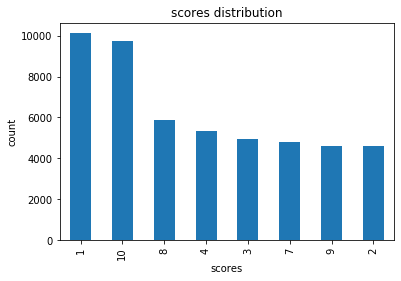

In [17]:
df['score'].value_counts().plot(kind = 'bar')
plt.title("scores distribution")
plt.xlabel('scores')
plt.ylabel('count')

Рисунок выше наглядно отображает неравномерное распределение оценок, что может влиять на качество решения многоклассовой классификации, что в свою очередь косвенно может влиять на качество конечной модели.

## Запекание (сериализация) модели

In [18]:
class Classifier():
    def __init__(self, model, tf_idf_vectorizer):
        self.logit = model
        self.tf_idf_vectorizer = tf_idf_vectorizer
    
    
    def strip_html(self, text):
        soup = BeautifulSoup(text, 'html.parser')
        return soup.get_text()


    # Удаление квадратных скобок
    def remove_square_brackets(self, text):
        return re.sub('\[[^]]*\]', '', text)


    # Общая чистка
    def clean_text(self, text):
        text = self.strip_html(text)
        text = self.remove_square_brackets(text)
        return text
    
    
    # Глубокая чистка 
    def deep_cleaning(self, text, remove_digits=True):
        pattern = r'[^a-zA-z0-9\s]'
        text = re.sub(pattern, '', text)
        return text
    
    
    def processing (self, text):
        text = self.clean_text(text)
        text = self.deep_cleaning(text)
        text_vec = self.tf_idf_vectorizer.transform([text,])
        score  = int(self.logit.predict(text_vec))
        tone =  1*np.sign(score-5)
        return (tone, score)
        

In [19]:
import pickle

clf_model = Classifier(logit, tf_idf_vec)
filename = 'logit_model.sav'
pickle.dump(clf_model, open(filename, 'wb'))

### Отдельно сериализуем для Django так, как pickle объекты это фреймворк десериализовывать не хочет

In [20]:
from sklearn.externals import joblib

model = logit

filename_1 = 'model.pkl'
filename_2 = 'tf_idf_vec.pkl'

joblib.dump(model, filename_1)
joblib.dump(tf_idf_vec, filename_2)

/Users/user/Documents/GitHub/mlcourse.ai/env/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['tf_idf_vec.pkl']

In [22]:
# Тут же и проверим работоспособность 
clf = joblib.load(filename_1)
vec = joblib.load(filename_2)

review = 'Really it\'s a dreadful cheat of a film. Its 70-minute running time is very well padded with stock footage. The rest are non descript exteriors and drab interiors scenes. The plot exposition is very poorly rendered. They are all just perfunctory scenes sort of strung together. There is no attempt at drama in scene selection but rather drama is communicated by the intensity of the actors. Please don\'t ask.<br /><br />The plot concerns a rocket radiating a million degree heat orbiting earth five miles up threatening to destroy the earth. It\'s a real time menace that must be diverted if a custom built H-bomb can be fashioned and placed in an experimental rocket within an hour. Nothing very much here to report except for a mad speech by a scientist against the project because there might be some sort of life aboard and think of the scientific possibilities but this speech made by the obligatory idiot liberal was pretty much passé by then.<br /><br />What saves this film, somewhat uniquely, IS the stock footage. I\'ve never seen a larger selection of fifties jet fighter aircraft in any other film. This is by no means a complete list but just some of the aircraft I managed to see. There\'s a brief interception by a pilot flying, in alternate shots, an F-89 Scorpion and an F-86. First to scramble interceptors is the Royal Canadian Air Force in Hawker Hunters and F-86 Sabre Jets (or Canadian built CF-13s) and even a pair of CF-100 Clunks.<br /><br />Then for some reason there are B-52s, B-47s and even B36s are seen taking off. More padding.<br /><br />"These Canadian jets are moving at 1200 miles an hour". I don\'t think so since one of them appears to be a WW2 era Gloster Meteor, the rest F-80s. The Meteors press the attack and one turns into a late F-84F with a flight of early straight wing F-84s attacking in formation.<br /><br />There\'s a strange tandem cockpit version of the F-80 that doesn\'t seem to be the T-33 training type but some sort of interim all-weather interceptor variant with radar in the nose. These are scrambled in a snowstorm.<br /><br />An angled deck aircraft carrier is seen from about 500 meters. It launches F-8U Crusaders, F-11F Tigers, A-5 Vigilantes and A-3 Skywarriors. The Air Force scrambles F-86s and F-84s and more F-89s then you\'ve ever seen in your life as well as F-100 Super Sabres and F-102 Delta Daggers.<br /><br />The F-100s press their attack with sooooo much padding. The F-89\'s unload their rockets in their wingtip pods in slo mo. The F-86s fire, an F-102 lets loose a Falcon, even some F-80s (F-94s?) with mid-wing rocket pods let loose. There is a very strange shot of a late model F-84 (prototype?) with a straight wing early model F-85 above it in a turn, obviously a manufacturer\'s (Republic Aviation) advertising film showing the differences between the old and the new improved models of the F-84 ThunderJet. How it strayed into here is anybodies guess.<br /><br />There is other great stock footage of Ottawa in the old days when the capital of Canada was a wide spot in the road and especially wonderful footage of New York City\'s Times Square during one of the Civil Defense Drills in the early 50s. <br /><br />I think we also have to deal with the notion that this was filmed in Canada with the possible exception of the auto chase seen late in the picture as the Pacific seems to be in the background. The use of a Jowett Jupiter is somewhat mind-boggling and there is a nice TR 3 to be seen also. Canada must have been cheap and it is rather gratuitously used a lot in the background.<br /><br />As far as the actual narrative of the film there is little to recommend it other than the mystery of just who Ellen Parker is giving the finger to at the end of the picture. And she most definitely is flipping someone off. Could it be, R as in Robert Loggia? The director who dies before this film was released? Her career as this was her last credit?<br /><br />Its like the newspaper the gift came wrapped in was more valuable than the gift.'
review = vec.transform([review,])
clf.predict(review)

array(['3'], dtype=object)